In [1]:
import sys
sys.path.insert(0, '../')
from lib import *

%matplotlib inline

DEBUG = False;

def gauss(x, a, x0, sigma):
    return a*np.exp(-(x-x0)**2/(2*sigma**2))


In [2]:
SAMPLING=4e-9
BITS= 16384
DYNAMIC_RANGE= 2
AMP= np.array([250,250,250,250,1030])
e_charge=1.60217663 * 1e-19

#                           ADCs to V     ticks to sec          C to e-      still need to correct by Gain of specific run
ADCxTicks2e=       DYNAMIC_RANGE/BITS     * SAMPLING  / AMP  /e_charge
GAIN=np.array([6.36E+06,	6.61E+06,	6.66E+06,	6.63E+06,	3.00E+06]) #from calibrations, AT 4/2.5v
ADCxTicks2PE=ADCxTicks2e/GAIN


## Single Run

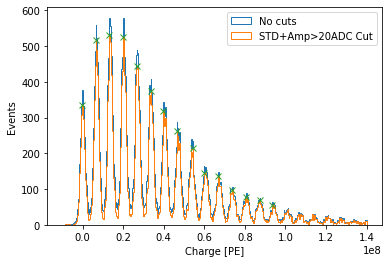

In [48]:
# Let's create a function to model and create data

# WEEK="APSAIA_VUV";
WEEK="DAPHNE_VIS";
path="/scr/neutrinos/rodrigoa/"+WEEK+"/joython/"
Runs=open_runs_table("../macros/"+WEEK+".xlsx")
Runs=Runs[Runs["Type"]=="Alfa"]

for ch in [5]:
    r=0;
    # for run in Runs["Run"].array:
    for run in [4]:
        Run_props=open_run_properties(run,"../macros/APSAIA_VIS.xlsx")
        run_path=path+"run"+str(run).zfill(2)+"/";
        compress=False
        Pedestal_vars=open_run_var(run_path,"Pedestal_vars",[ch],compressed=compress)
        Charge_vars  =open_run_var(run_path ,"Charge_vars" ,[ch],compressed=compress)
        Peak_vars    =open_run_var(run_path ,"Peak_vars"   ,[ch],compressed=compress)


Ped_CUT=Pedestal_vars[ch]["STD"]<20

plt.hist(Charge_vars[ch]["ChargeRangeAverageWvf"]                        *ADCxTicks2e [4],500,np.array([-0.1,1.4])*1e8,histtype="step");
plt.hist(Charge_vars[ch]["ChargeRangeAverageWvf"][Ped_CUT]               *ADCxTicks2e [4],500,np.array([-0.1,1.4])*1e8,histtype="step");

counts,bins=np.histogram(Charge_vars[ch]["ChargeRangeAverageWvf"][Ped_CUT]               *ADCxTicks2e [4],500,np.array([-0.1,1.4])*1e8);

# std=np.std(Charge_vars[0]["PeakFinderInRange"][Ped_CUT*Peak_vars[ch]["Peak"]>40]*ADCxTicks2PE[4])

# popt, pcov = curve_fit(gauss, bins[1:], counts,p0=[max(counts),bins[np.argmax(counts)],std])


# print(sum(gauss(np.arange(0,1e8),popt[0], popt[1], popt[2])) ) 

# ym = gauss(bins[1:], popt[0], popt[1], popt[2])
# plt.plot  (bins[1:], ym, c='r', label='Best fit')

# plt.semilogy()

plt.legend(["No cuts","STD+Amp>20ADC Cut","STD+Amp>40ADC Cut","Best Fit"],loc="upper right")
plt.xlabel("Charge [PE]")
plt.ylabel("Events")
# plt.ylim([1,2e3])

peaks=find_peaks(counts,height=50,width=5)
plt.plot(bins[peaks[0]],peaks[1]["peak_heights"],"x")

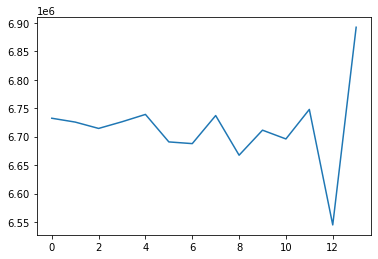

In [55]:
%matplotlib inline
gains=vars[1::3]-vars[1]
gains=gains[1:]-gains[0:-1]
plt.plot(gains)

[ 3.34e+02 -1.00e+05  1.00e+06  5.16e+02  6.50e+06  1.00e+06  5.32e+02
  1.31e+07  1.00e+06  5.24e+02  2.00e+07  1.00e+06  4.45e+02  2.66e+07
  1.00e+06  3.74e+02  3.35e+07  1.00e+06  3.17e+02  3.98e+07  1.00e+06
  2.63e+02  4.64e+07  1.00e+06  2.14e+02  5.42e+07  1.00e+06  1.46e+02
  5.99e+07  1.00e+06  1.36e+02  6.68e+07  1.00e+06  9.70e+01  7.37e+07
  1.00e+06  7.90e+01  8.06e+07  1.00e+06  6.90e+01  8.72e+07  1.00e+06
  5.60e+01  9.35e+07  1.00e+06]
[ 3.24266218e-04 -1.62778207e-01  1.14022071e+00  4.92583716e-04
  6.56950488e+00  1.13604004e+00  5.24113393e-04  1.32950306e+01
  1.13814519e+00  5.04455991e-04  2.00094037e+01  1.16552979e+00
  4.45453489e-04  2.67355054e+01  1.15556912e+00  3.66637410e-04
  3.34744917e+01  1.21253380e+00  3.06868461e-04  4.01651891e+01
  1.24703108e+00  2.47538129e-04  4.68528884e+01  1.25067060e+00
  2.01452399e-04  5.35898750e+01  1.27478037e+00  1.47584094e-04
  6.02572349e+01  1.41005864e+00  1.28777935e-04  6.69685513e+01
  1.31732723e+00  9.20

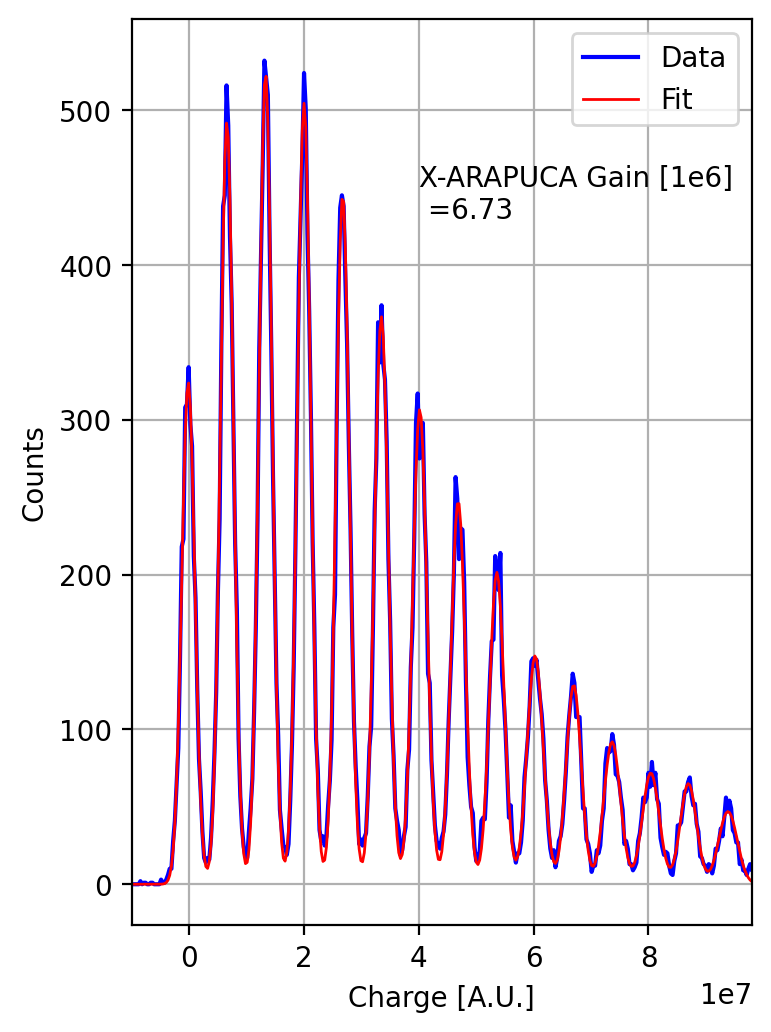

In [84]:
%matplotlib inline

def gauss(x,a,x0,sigma):
    return a*np.exp(-0.5*np.power((x-x0)/sigma,2))

def gaussian_train(x, *params):
    y = np.zeros_like(x)
    for i in range(0, len(params), 3):
        height = params[i]
        center = params[i+1]
        width  = params[i+2]
        y      +=  gauss(x, height, center, width)
    return y

def fit_gaussians(x, y, *p0):
    assert x.shape == y.shape, "Input arrays must have the same shape."
    print(p0[0])
    # try:
    popt, pcov = curve_fit(gaussian_train, x,y, p0=p0[0])
    fit_y=gaussian_train(x,*popt)
    chi_squared = np.sum((y[abs(fit_y)>0.1] - fit_y[abs(fit_y)>0.1]) ** 2 / fit_y[abs(fit_y)>0.1]) / (y.size - len(popt))
    plt.figure(dpi=200, figsize=(4, 6))
    fig = plt.axes()
    plt.plot(x, y, 'b-', label='data')
    plt.plot(x, fit_y, 'r-', label='fit',linewidth=1)
    plt.grid()
    return popt,fig, chi_squared
    # except:
    #     print("Fit failed.")


params=np.zeros(len(peaks[0])*3)
params[0::3]=peaks[1]["peak_heights"]
params[1::3]=bins[peaks[0]]
params[2::3]=1e6
vars,fig,qs=fit_gaussians(bins[:-1],counts,params)
print(vars*1e-6)
fig.set_xlim([-1e7,0.98e8])
fig.set_xlabel("Charge [A.U.]")
fig.set_ylabel("Counts")
fig.legend(["Data","Fit"],loc="upper right")
fig.text(0.4e8,430,"X-ARAPUCA Gain [1e6] \n =%0.2f" % (gains[0]*1e-6));
print(qs)
# fig.set_ylim([1,2e3])
# fig.set_yscale("log")

## Multiple Runs: amplitude

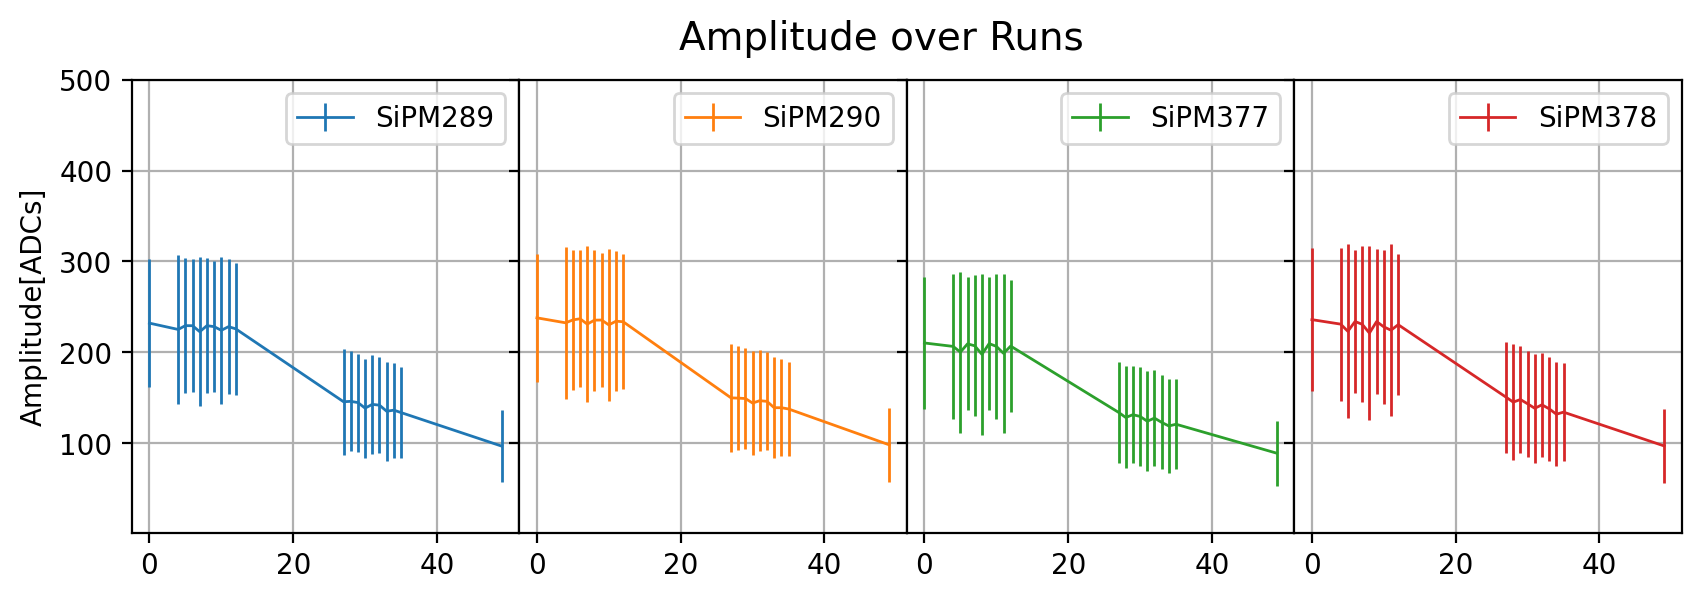

In [22]:
Runs=Runs[Runs["Type"]=="Alfa"]


amp  =np.zeros((len(Run_props["Channels"]),Runs["Run"].array.shape[0]))
mean =np.zeros((len(Run_props["Channels"]),Runs["Run"].array.shape[0]))
err  =np.zeros((len(Run_props["Channels"]),Runs["Run"].array.shape[0]))
rate =np.zeros((len(Run_props["Channels"]),Runs["Run"].array.shape[0]))

i=0

for ch in Run_props["Channels"]:
# for ch in [0]:
    r=0;
    for run in Runs["Run"].array:
    # for run in [0]:
        
        Run_props=open_run_properties(run,"../macros/APSAIA_VUV.xlsx")
        run_path=path+"run"+str(run).zfill(2)+"/";
        compress=False
        Pedestal_vars=open_run_var(run_path,"Pedestal_vars",[ch],compressed=compress)
        Charge_vars  =open_run_var(run_path ,"Charge_vars" ,[ch],compressed=compress)
        Peak_vars    =open_run_var(run_path ,"Peak_vars"   ,[ch],compressed=compress)
        TS=open_run_var(run_path,"Timestamp",[ch],compressed=compress)

        Ped_CUT=Pedestal_vars[ch]["STD"]<10
        counts,bins=np.histogram(Peak_vars[ch]["Peak"][Ped_CUT*Peak_vars[ch]["Peak"]>40],100,[0,1000]);
        
        # plt.hist(Peak_vars[ch]["Peak"][Ped_CUT*Peak_vars[ch]["Peak"]>40],100,[0,1000]);

        std=np.std(Peak_vars[ch]["Peak"][Ped_CUT*Peak_vars[ch]["Peak"]>40])

        try: 
            popt, pcov = curve_fit(gauss, bins[1:], counts,p0=[max(counts),bins[np.argmax(counts)],std])
            amp [i,r]=popt[0]
            mean[i,r]=popt[1]
            err [i,r]=popt[2]
        except:
            amp [i,r]=0
            mean[i,r]=0
            err [i,r]=0

        
        r+=1;
    i+=1;


x=Runs["Run"].array
ys=mean[:4]
yer=err[:4]
legend=Run_props["ChannelName"][:4]

fig,axs=horizontal_subplots(x,ys,yer,legend)
plt.suptitle("Amplitude over Runs", fontsize=14)
axs[0].set_ylabel("Amplitude[ADCs]")
for ax in axs: ax.set_ylim([2,500])

## Single Run, Amplitude

168622.8808309386


(1.0, 1000.0)

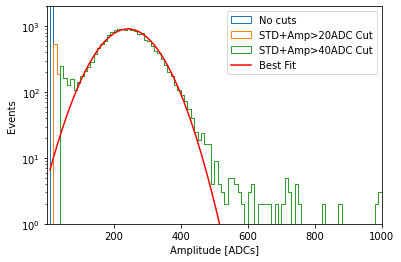

In [38]:
# Let's create a function to model and create data

for ch in [0]:
    r=0;
    # for run in Runs["Run"].array:
    for run in [0]:
        Run_props=open_run_properties(run,"../macros/APSAIA_VUV.xlsx")
        run_path=path+"run"+str(run).zfill(2)+"/";
        compress=False
        Pedestal_vars=open_run_var(run_path,"Pedestal_vars",[ch],compressed=compress)
        Charge_vars  =open_run_var(run_path ,"Charge_vars" ,[ch],compressed=compress)
        Peak_vars    =open_run_var(run_path ,"Peak_vars"   ,[ch],compressed=compress)


Ped_CUT=Pedestal_vars[0]["STD"]<6

plt.hist(Peak_vars[0]["Peak"]                                 ,100,[0,1e3],histtype="step");
plt.hist(Peak_vars[0]["Peak"][Ped_CUT*Peak_vars[0]["Peak"]>20],100,[0,1e3],histtype="step");
plt.hist(Peak_vars[0]["Peak"][Ped_CUT*Peak_vars[0]["Peak"]>40],100,[0,1e3],histtype="step");
counts,bins=np.histogram(Peak_vars[0]["Peak"][Ped_CUT*Peak_vars[0]["Peak"]>40],100,[0,1e3]);

std=np.std(Peak_vars[0]["Peak"][Ped_CUT*Peak_vars[0]["Peak"]>40])

popt, pcov = curve_fit(gauss, bins[1:], counts,p0=[max(counts),bins[np.argmax(counts)],std])


print(sum(gauss(np.arange(0,1e8),popt[0], popt[1], popt[2])) ) 

ym = gauss(bins[1:], popt[0], popt[1], popt[2])
plt.plot  (bins[1:], ym, c='r', label='Best fit')

plt.semilogy()

plt.legend(["No cuts","STD+Amp>20ADC Cut","STD+Amp>40ADC Cut","Best Fit"])
plt.xlabel("Amplitude [ADCs]")
plt.ylabel("Events")
plt.ylim([1,2e3])
plt.xlim([1,1e3])
